# Linear Regression

## Прогнозирование просмотров

In [211]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids21.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [212]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if not item.endswith("22")]

В зависимости от задачи (подзадачи) таргеты будут разными.

In [213]:
target_4 = ["views_22", "comments_22", "likes_22", "dislikes_22"]
target_views = ["views_22"]
target_likes = ["likes_22"]
target_dislikes = ["dislikes_22"]
target_comments = ["comments_22"]

In [214]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_views]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [215]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

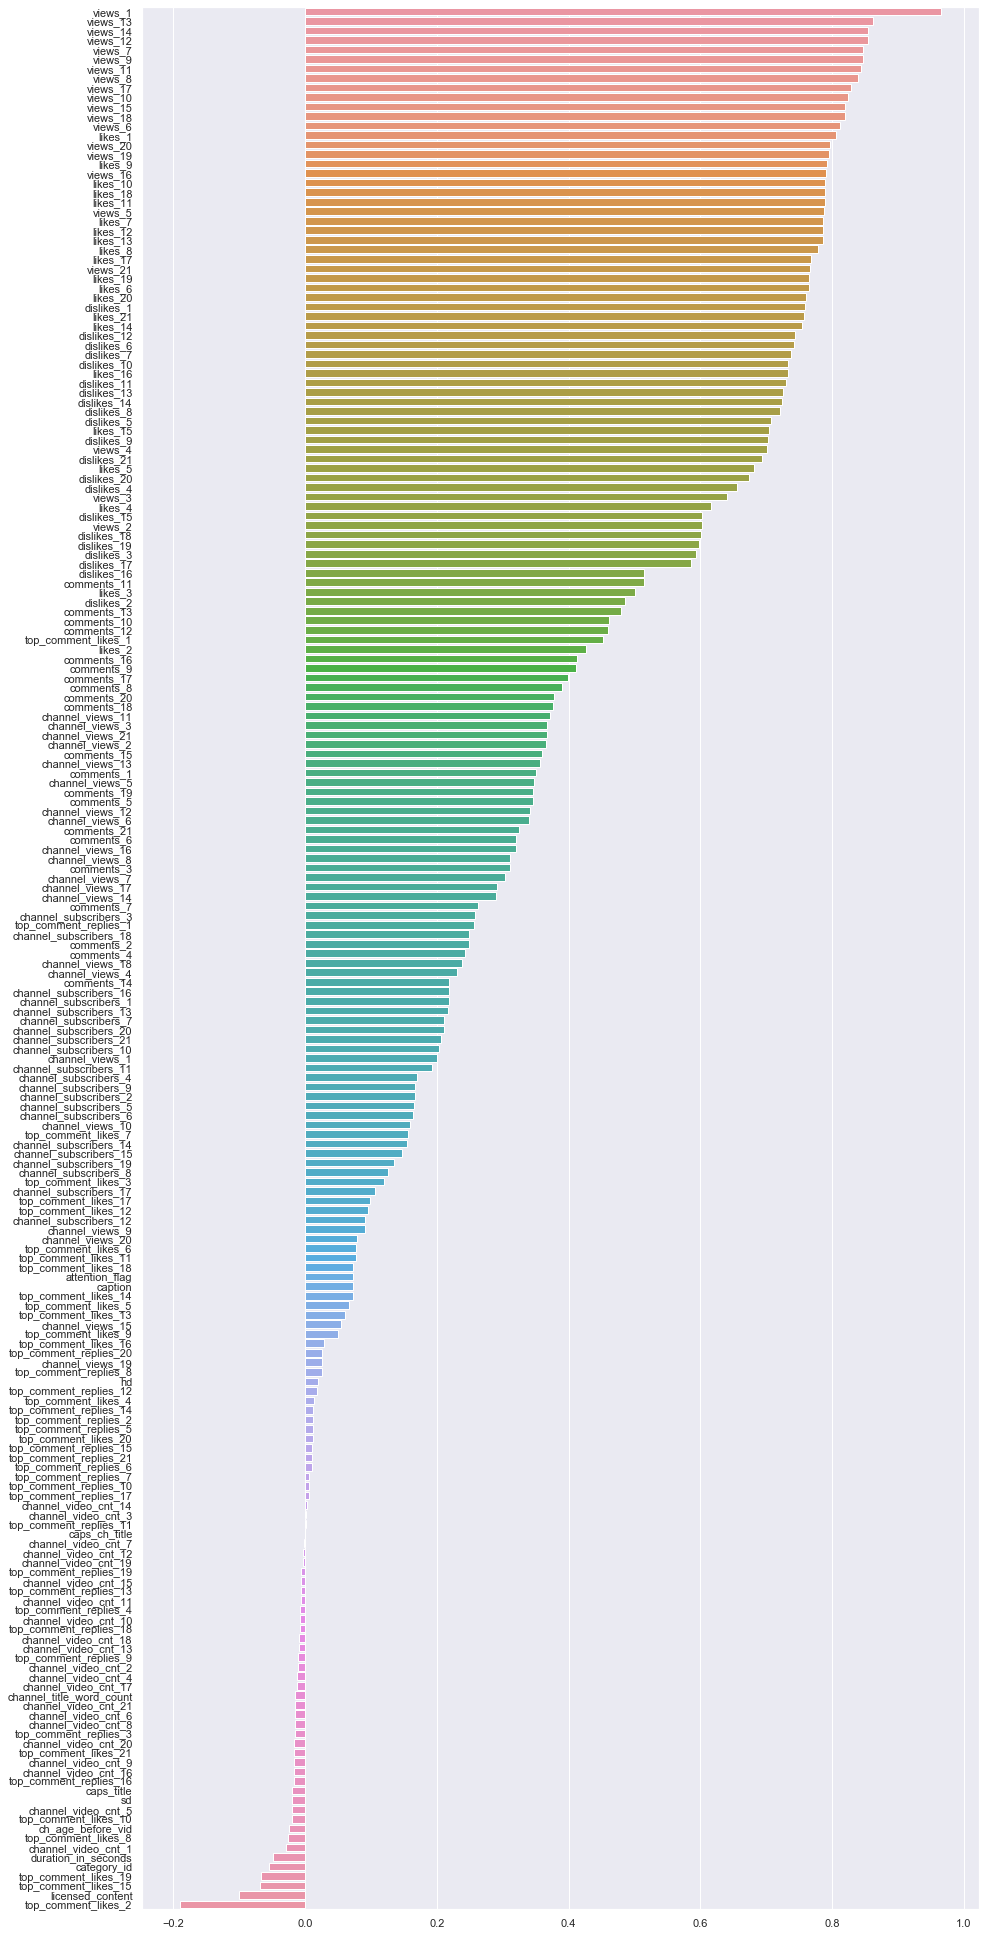

In [216]:
correlations_views = X_train.corrwith(y_train["views_22"]).sort_values(ascending=False)
plot_views = sns.barplot(y=correlations_views.index, x=correlations_views)
plot_views.figure.set_size_inches(15, 35)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [217]:
corr_df = pd.DataFrame(data={"features": correlations_views.index, "importance": correlations_views.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.58]["features"].values)

In [218]:
corr_df[corr_df["importance"] >= 0.58].features.values

array(['views_1', 'views_13', 'views_14', 'views_12', 'views_7',
       'views_9', 'views_11', 'views_8', 'views_17', 'views_10',
       'views_15', 'views_18', 'views_6', 'likes_1', 'views_20',
       'views_19', 'likes_9', 'views_16', 'likes_10', 'likes_18',
       'likes_11', 'views_5', 'likes_7', 'likes_12', 'likes_13',
       'likes_8', 'likes_17', 'views_21', 'likes_19', 'likes_6',
       'likes_20', 'dislikes_1', 'likes_21', 'likes_14', 'dislikes_12',
       'dislikes_6', 'dislikes_7', 'dislikes_10', 'likes_16',
       'dislikes_11', 'dislikes_13', 'dislikes_14', 'dislikes_8',
       'dislikes_5', 'likes_15', 'dislikes_9', 'views_4', 'dislikes_21',
       'likes_5', 'dislikes_20', 'dislikes_4', 'views_3', 'likes_4',
       'dislikes_15', 'views_2', 'dislikes_18', 'dislikes_19',
       'dislikes_3', 'dislikes_17'], dtype=object)

In [219]:
X = df[important_features]
y = df[target_views]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [220]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [221]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 15111.7228
Train RMSE = 8248.7496


In [222]:
y_all_pred = model.predict(X)
np.int64(y_all_pred)

array([[1088930],
       [1264760],
       [  90163],
       ...,
       [ 562469],
       [ 706712],
       [3492198]])

In [223]:
fc = (pd.DataFrame(np.int64(y_all_pred), columns=["views_forecast"]))

In [224]:
pd.DataFrame(fc["views_forecast"].values, columns=["views_forecast"])

views_forecast
0            1088930
1            1264760
2              90163
3             477838
4              79184
...              ...
7562           54521
7563         1059222
7564          562469
7565          706712
7566         3492198

[7567 rows x 1 columns]

In [225]:
df_copy = df.copy()
df_copy = df_copy.assign(views_forecast=pd.Series(fc["views_forecast"].values))

In [226]:
df_copy[["video_id", "views_22", "views_forecast"]].sample(10)

video_id    views_22  views_forecast
2170  OW4aOlOjaCg    370555.0          372336
4777  MBhkfb3k6Xg    179352.0          179443
2545  ujkG_0y53uQ  26834598.0        26863774
299   mPyieTyePj0    163072.0          162855
687   PgmJW1ZZLD0     65920.0           66175
3265  nnjTpXmiA_M    184976.0          185047
2081  0r2ZTij3EoA    969337.0          968308
1578  K-lxmnSSSyo    465647.0          466023
485   L6GiPS_KZos   9270070.0         9272659
4271  pxnT8TT_I3Q    392087.0          392081

Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

In [227]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

Best alpha = 0.37926902


Text(0, 0.5, 'CV score')

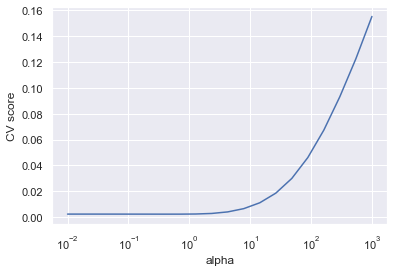

In [228]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.8f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [229]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0013
Train RMSE = 0.0008
Test MSE = 0.00000179
Train MSE = 0.00000072


In [230]:
model

Ridge(alpha=0.37926901907322497, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [231]:
from sklearn.metrics import mean_absolute_error

print("Test MAE = %.8f" % mean_absolute_error(y_test_scaled, y_pred))

Test MAE = 0.00030154


In [232]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_test_scaled, y_pred)

0.2673482007293921

In [233]:
from sklearn.metrics import r2_score

r2_score(y_test_scaled, y_pred)

0.9999971967290997

In [22]:
mean_absolute_percentage_error(y_test_scaled, y_pred)

0.2673482007293921

In [23]:
model

Ridge(alpha=0.37926901907322497, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [24]:
y_inverse = scaler.inverse_transform(y_pred)

In [25]:
y_inverse

array([[11786205.62850496],
       [  585771.81722371],
       [14874967.80434377],
       ...,
       [  723519.91609649],
       [   80151.34203417],
       [ 4607421.03146093]])

In [26]:
y_inverse = np.int64(y_inverse)

In [27]:
print("Test MSE = %.8f" % mean_squared_error(y_test, y_inverse, squared=True))

Test MSE = 179364752.94804052


In [28]:
mean_absolute_percentage_error(y_test, y_inverse)

0.1870575963171234

In [29]:
r2_score(y_test, y_inverse)

0.9999971967256183

In [30]:
pd.DataFrame(y_inverse, columns=["views_forecast"])

views_forecast
0           11786205
1             585771
2           14874967
3             991262
4           19058539
...              ...
2266          158205
2267          229786
2268          723519
2269           80151
2270         4607421

[2271 rows x 1 columns]

Получим предсказания просмотров по всем видео.

In [31]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [32]:
y_all_pred = model.predict(X_scaled)
y_all_pred

array([[-0.14315065],
       [-0.12640322],
       [-0.24866445],
       ...,
       [-0.20018615],
       [-0.18257094],
       [ 0.1151112 ]])

In [33]:
y_all_pred.shape

(7567, 1)

In [34]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [35]:
pd.DataFrame(np.int64(y_inv), columns=["views_forecast"])

views_forecast
0            1126642
1            1284923
2             129424
3             524030
4             118651
...              ...
7562           92437
7563         1080882
7564          587595
7565          754078
7566         3567492

[7567 rows x 1 columns]

In [36]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["views_forecast"])

In [37]:
forecast_["views_forecast"].values

array([1126642, 1284923,  129424, ...,  587595,  754078, 3567492])

In [38]:
df_copy = df.copy()
df_copy = df_copy.assign(forecast=pd.Series(forecast_["views_forecast"].values))

In [39]:
df_copy[["video_id", "views_22", "forecast"]]

video_id   views_22  forecast
0     HfGRNUOqhLk  1092141.0   1126642
1     Kk5naOEL3gQ  1264719.0   1284923
2     4bKuBuPB_QA    90201.0    129424
3     eYOIhHu2gho   477820.0    524030
4     0NDPSeDiYBI    79062.0    118651
...           ...        ...       ...
7562  vlasHLCqsEQ    54431.0     92437
7563  pl4jSXEp-8w  1060500.0   1080882
7564  uiaTjPsnE5k   562812.0    587595
7565  cuHvxIy-CDc   705495.0    754078
7566  W2pgpUhxbag  3490575.0   3567492

[7567 rows x 3 columns]

In [40]:
X = df[features]
y = df[target_views]

In [41]:
mu, sigma = 0, 0.001
noise_x = np.random.normal(mu, sigma, X_train.shape)
noise_x

array([[ 4.37124896e-04,  2.50255607e-04,  6.28133859e-04, ...,
         1.35773351e-03, -9.52328214e-04, -7.16989321e-04],
       [ 1.20994390e-03,  8.14291987e-04,  2.83627550e-04, ...,
         8.46251999e-04, -7.17466646e-04, -2.24027732e-03],
       [-2.01198035e-03, -7.27428533e-04,  5.84766400e-04, ...,
        -2.80301762e-04, -4.97202972e-04,  6.30955123e-06],
       ...,
       [ 7.35997009e-04, -7.97823454e-04,  1.83435950e-03, ...,
        -9.21194949e-04, -1.77319185e-03,  1.32503489e-04],
       [-9.89735760e-05, -1.83026452e-04, -1.70959706e-03, ...,
         4.51854302e-04,  4.08285881e-04, -9.82517655e-04],
       [ 3.54617464e-04,  8.59999357e-05, -2.02873938e-03, ...,
        -1.25154938e-03,  1.67305569e-03, -7.68988717e-04]])

In [42]:
scaler = StandardScaler()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

noise_x_tr = np.random.normal(mu, sigma, X_train.shape)
noise_x_test = np.random.normal(mu, sigma, X_test.shape)
noise_y_tr = np.random.normal(mu, sigma, y_train.shape)
noise_y_test = np.random.normal(mu, sigma, y_test.shape)

X_train_scaled += noise_x_tr
X_test_scaled += noise_x_test
y_train_scaled += noise_y_tr
y_test_scaled += noise_y_test

model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0020
Train RMSE = 0.0014
Test MSE = 0.00000388
Train MSE = 0.00000202


In [44]:
r2_score(y_test_scaled, y_pred)

0.9999939261312286

## Прогнозирование лайков

Повторим процедуру для лайков. Точно так же будем определять значение коэффициента Пирсона, при котором отобранные признаки дают наилучшее качество модели.

In [234]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids21.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [235]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if not item.endswith("22")]

В зависимости от задачи (подзадачи) таргеты будут разными.

In [236]:
# target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
# target_views = ["views_7"]
target_likes = ["likes_22"]
# target_dislikes = ["dislikes_7"]
# target_comments = ["dislikes_7"]

In [237]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_likes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

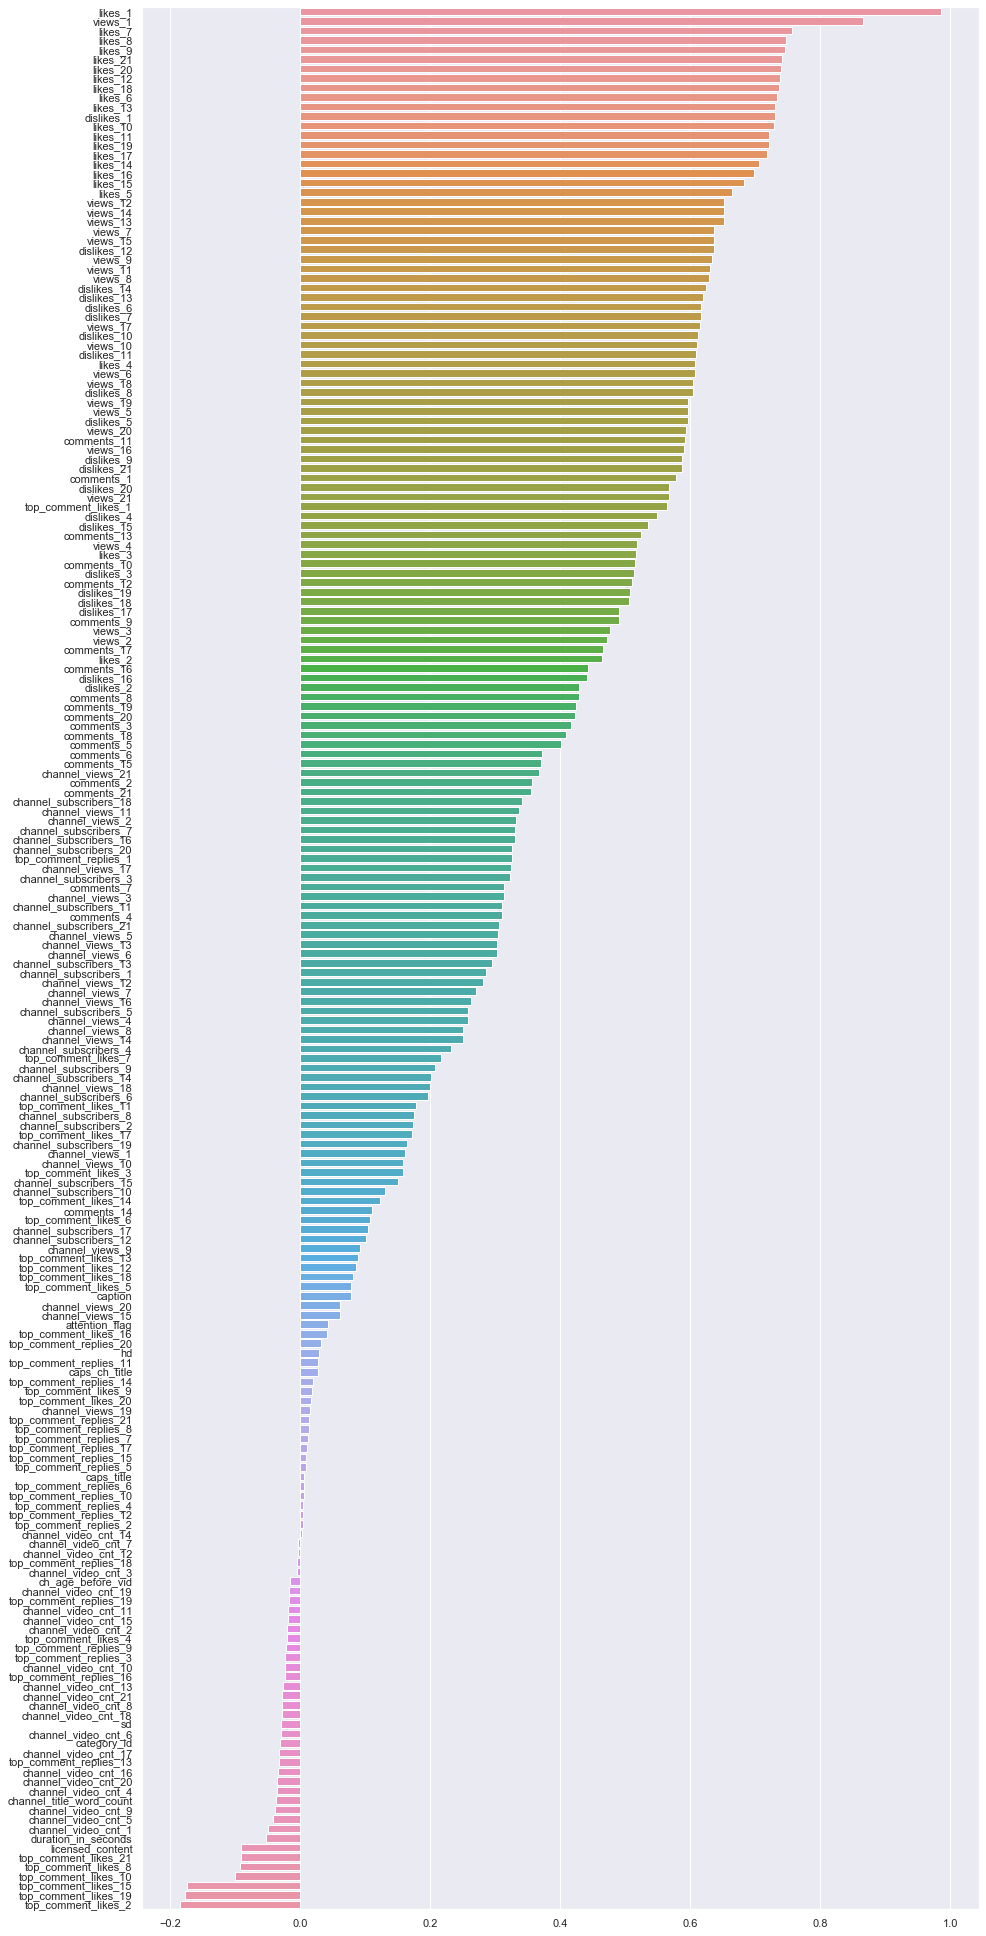

In [239]:
correlations_likes = X_train.corrwith(y_train["likes_22"]).sort_values(ascending=False)
plot_likes = sns.barplot(y=correlations_likes.index, x=correlations_likes)
plot_likes.figure.set_size_inches(15, 35)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [240]:
corr_df = pd.DataFrame(data={"features": correlations_likes.index, "importance": correlations_likes.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.25]["features"].values)

In [241]:
corr_df[(corr_df["importance"] >= 0.25)].features.values

array(['likes_1', 'views_1', 'likes_7', 'likes_8', 'likes_9', 'likes_21',
       'likes_20', 'likes_12', 'likes_18', 'likes_6', 'likes_13',
       'dislikes_1', 'likes_10', 'likes_11', 'likes_19', 'likes_17',
       'likes_14', 'likes_16', 'likes_15', 'likes_5', 'views_12',
       'views_14', 'views_13', 'views_7', 'views_15', 'dislikes_12',
       'views_9', 'views_11', 'views_8', 'dislikes_14', 'dislikes_13',
       'dislikes_6', 'dislikes_7', 'views_17', 'dislikes_10', 'views_10',
       'dislikes_11', 'likes_4', 'views_6', 'views_18', 'dislikes_8',
       'views_19', 'views_5', 'dislikes_5', 'views_20', 'comments_11',
       'views_16', 'dislikes_9', 'dislikes_21', 'comments_1',
       'dislikes_20', 'views_21', 'top_comment_likes_1', 'dislikes_4',
       'dislikes_15', 'comments_13', 'views_4', 'likes_3', 'comments_10',
       'dislikes_3', 'comments_12', 'dislikes_19', 'dislikes_18',
       'dislikes_17', 'comments_9', 'views_3', 'views_2', 'comments_17',
       'likes_2', 'comme

In [242]:
X = df[important_features]
y = df[target_likes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [243]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [244]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 225.5522
Train RMSE = 148.8211


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.3793


Text(0, 0.5, 'CV score')

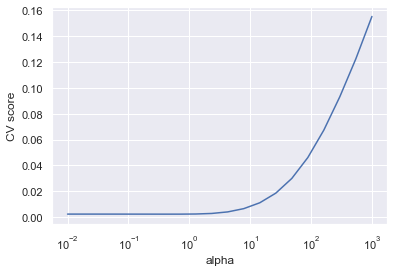

In [245]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [246]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [247]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0013
Train RMSE = 0.0005
Test MSE = 0.00000172
Train MSE = 0.00000030


In [248]:
model

Ridge(alpha=0.37926901907322497, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [249]:
y_inverse = scaler.inverse_transform(y_pred)

In [250]:
y_inverse

array([[254736.43712716],
       [ 77471.53164019],
       [209605.83640937],
       ...,
       [ 12420.89470671],
       [ 11106.42599144],
       [354136.28052771]])

In [251]:
y_inverse = np.int64(y_inverse)

In [252]:
r2_score(y_test, y_inverse)

0.999996770210786

In [171]:
pd.DataFrame(y_inverse, columns=["likes_forecast"])

likes_forecast
0             254808
1              77525
2             209723
3              14259
4             660475
...              ...
2266           12812
2267           16835
2268           12421
2269           11106
2270          354408

[2271 rows x 1 columns]

Получим предсказания просмотров по всем видео.

In [172]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [173]:
y_all_pred = model.predict(X_scaled)
y_all_pred

array([[ 0.15747861],
       [-0.12039156],
       [-0.25426781],
       ...,
       [-0.24750264],
       [-0.21277602],
       [ 0.52845129]])

In [67]:
y_all_pred.shape

(7567, 1)

In [68]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [69]:
pd.DataFrame(np.int64(y_inv), columns=["likes_forecast"])

likes_forecast
0             122532
1              42480
2               3822
3               8282
4               3247
...              ...
7562            2302
7563           38224
7564            5785
7565           15847
7566          229636

[7567 rows x 1 columns]

In [70]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["likes_forecast"])

In [71]:
forecast_["likes_forecast"].values

array([122532,  42480,   3822, ...,   5785,  15847, 229636])

In [72]:
df_copy = df.copy()
df_copy = df_copy.assign(likes_forecast=pd.Series(forecast_["likes_forecast"].values))

In [73]:
df_copy[["video_id", "likes_22", "likes_forecast"]]

video_id  likes_22  likes_forecast
0     HfGRNUOqhLk  123464.0          122532
1     Kk5naOEL3gQ   41523.0           42480
2     4bKuBuPB_QA    2644.0            3822
3     eYOIhHu2gho    7070.0            8282
4     0NDPSeDiYBI    2063.0            3247
...           ...       ...             ...
7562  vlasHLCqsEQ    1125.0            2302
7563  pl4jSXEp-8w   37399.0           38224
7564  uiaTjPsnE5k    4695.0            5785
7565  cuHvxIy-CDc   14731.0           15847
7566  W2pgpUhxbag  229486.0          229636

[7567 rows x 3 columns]

In [174]:
X = df[features]
y = df[target_likes]

In [175]:
mu, sigma = 0, 0.001
noise_x = np.random.normal(mu, sigma, X_train.shape)
noise_x

array([[-4.74419404e-06, -6.14447874e-04,  2.25966538e-03, ...,
         2.08189119e-03,  2.32321457e-03, -1.50282398e-04],
       [ 1.34278553e-03,  2.73864921e-03,  2.86727364e-04, ...,
        -3.98890350e-04, -4.22923458e-04,  2.85526494e-04],
       [ 1.35986624e-03,  4.39124968e-04, -1.15431520e-03, ...,
         1.32805716e-03, -1.64907034e-03, -1.17888189e-04],
       ...,
       [-8.95405697e-04, -8.02496740e-05, -7.43247554e-04, ...,
         3.93416440e-04,  3.65557727e-04, -5.13547621e-04],
       [ 5.19404547e-04,  1.01312585e-03, -2.45759297e-04, ...,
        -9.69350470e-04,  3.59861345e-04,  1.26685333e-03],
       [ 4.73076571e-04,  4.10600134e-04, -1.50028046e-03, ...,
        -9.48315731e-06, -1.53929466e-03,  1.03666113e-03]])

In [176]:
scaler = StandardScaler()

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

noise_x_tr = np.random.normal(mu, sigma, X_train.shape)
noise_x_test = np.random.normal(mu, sigma, X_test.shape)
noise_y_tr = np.random.normal(mu, sigma, y_train.shape)
noise_y_test = np.random.normal(mu, sigma, y_test.shape)

X_train_scaled += noise_x_tr
X_test_scaled += noise_x_test
y_train_scaled += noise_y_tr
y_test_scaled += noise_y_test

model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0016
Train RMSE = 0.0014
Test MSE = 0.00000266
Train MSE = 0.00000193


In [178]:
r2_score(y_test_scaled, y_pred)

0.9999950265198594

## Прогнозирование дизлайков

Аналогично для дизлайков.

In [253]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids21.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [254]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if not item.endswith("22")]

В зависимости от задачи (подзадачи) таргеты будут разными.

In [255]:
# target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
# target_views = ["views_7"]
# target_likes = ["likes_7"]
target_dislikes = ["dislikes_22"]
# target_comments = ["comments_7"]

In [256]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_dislikes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

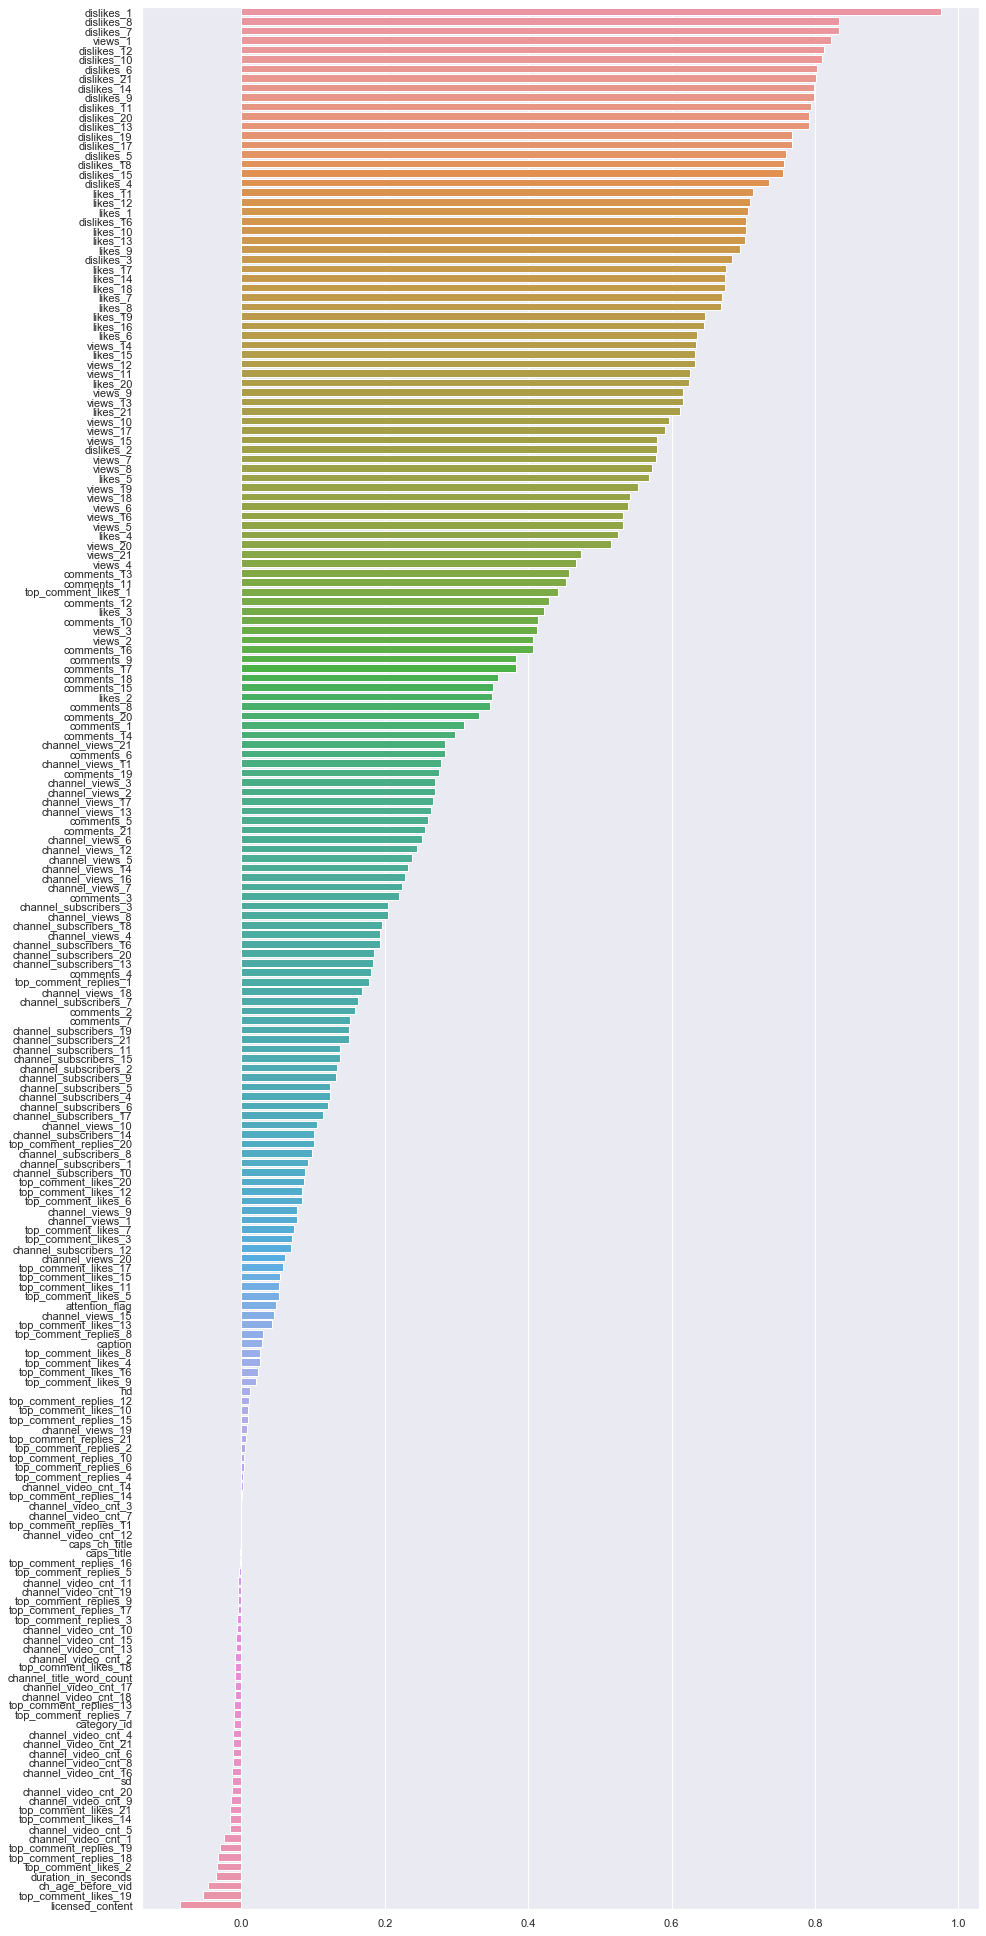

In [258]:
correlations_dislikes = X_train.corrwith(y_train["dislikes_22"]).sort_values(ascending=False)
plot_dislikes = sns.barplot(y=correlations_dislikes.index, x=correlations_dislikes)
plot_dislikes.figure.set_size_inches(15, 35)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [259]:
corr_df = pd.DataFrame(data={"features": correlations_dislikes.index, "importance": correlations_dislikes.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.15]["features"].values)

In [260]:
corr_df[corr_df["importance"] >= 0.15].features.values

array(['dislikes_1', 'dislikes_8', 'dislikes_7', 'views_1', 'dislikes_12',
       'dislikes_10', 'dislikes_6', 'dislikes_21', 'dislikes_14',
       'dislikes_9', 'dislikes_11', 'dislikes_20', 'dislikes_13',
       'dislikes_19', 'dislikes_17', 'dislikes_5', 'dislikes_18',
       'dislikes_15', 'dislikes_4', 'likes_11', 'likes_12', 'likes_1',
       'dislikes_16', 'likes_10', 'likes_13', 'likes_9', 'dislikes_3',
       'likes_17', 'likes_14', 'likes_18', 'likes_7', 'likes_8',
       'likes_19', 'likes_16', 'likes_6', 'views_14', 'likes_15',
       'views_12', 'views_11', 'likes_20', 'views_9', 'views_13',
       'likes_21', 'views_10', 'views_17', 'views_15', 'dislikes_2',
       'views_7', 'views_8', 'likes_5', 'views_19', 'views_18', 'views_6',
       'views_16', 'views_5', 'likes_4', 'views_20', 'views_21',
       'views_4', 'comments_13', 'comments_11', 'top_comment_likes_1',
       'comments_12', 'likes_3', 'comments_10', 'views_3', 'views_2',
       'comments_16', 'comments_9', 'c

In [261]:
X = df[important_features]
y = df[target_dislikes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [262]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [263]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 22.0488
Train RMSE = 14.4838


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.01000000


Text(0, 0.5, 'CV score')

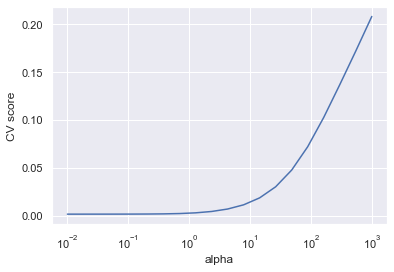

In [264]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.8f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [265]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [266]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0012
Train RMSE = 0.0008
Test MSE = 0.00000152
Train MSE = 0.00000066


In [267]:
model

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [268]:
y_inverse = scaler.inverse_transform(y_pred)

In [269]:
y_inverse

array([[17951.56875224],
       [ 1218.83491143],
       [16613.86459637],
       ...,
       [  578.5134601 ],
       [   96.84318894],
       [ 3622.54674578]])

In [270]:
y_inverse = np.int64(y_inverse)

In [271]:
r2_score(y_test, y_inverse)

0.9999977519245685

In [198]:
pd.DataFrame(y_inverse, columns=["dislikes_forecast"])

dislikes_forecast
0                 17963
1                  1218
2                 16645
3                   494
4                 17360
...                 ...
2266                215
2267                347
2268                578
2269                 96
2270               3623

[2271 rows x 1 columns]

Получим предсказания просмотров по всем видео.

In [99]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [100]:
y_all_pred = model.predict(X_scaled)
y_all_pred

array([[-0.12220987],
       [-0.1316887 ],
       [-0.15775251],
       ...,
       [-0.14008069],
       [-0.05124035],
       [ 0.06058284]])

In [101]:
y_all_pred.shape

(7567, 1)

In [102]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [103]:
pd.DataFrame(np.int64(y_inv), columns=["dislikes_forecast"])

dislikes_forecast
0                   747
1                   586
2                   145
3                   323
4                   136
...                 ...
7562                 58
7563               1797
7564                444
7565               1949
7566               3843

[7567 rows x 1 columns]

In [104]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["dislikes_forecast"])

In [105]:
forecast_["dislikes_forecast"].values

array([ 747,  586,  145, ...,  444, 1949, 3843])

In [106]:
df_copy = df.copy()
df_copy = df_copy.assign(dislikes_forecast=pd.Series(forecast_["dislikes_forecast"].values))

In [107]:
df_copy[["video_id", "dislikes_22", "dislikes_forecast"]]

video_id  dislikes_22  dislikes_forecast
0     HfGRNUOqhLk        701.0                747
1     Kk5naOEL3gQ        571.0                586
2     4bKuBuPB_QA        112.0                145
3     eYOIhHu2gho        281.0                323
4     0NDPSeDiYBI        101.0                136
...           ...          ...                ...
7562  vlasHLCqsEQ         27.0                 58
7563  pl4jSXEp-8w       1793.0               1797
7564  uiaTjPsnE5k        421.0                444
7565  cuHvxIy-CDc       1859.0               1949
7566  W2pgpUhxbag       3697.0               3843

[7567 rows x 3 columns]

In [199]:
X = df[features]
y = df[target_dislikes]

In [200]:
mu, sigma = 0, 0.001
noise_x = np.random.normal(mu, sigma, X_train.shape)
noise_x

array([[ 6.83046109e-04, -8.46837468e-06,  1.86725792e-04, ...,
         1.08511813e-03,  1.87747879e-04, -5.90775102e-04],
       [ 1.34359233e-04, -3.77912738e-04, -1.58687842e-05, ...,
         7.03025965e-04, -1.34685934e-04,  7.06137923e-05],
       [ 1.02436286e-04, -7.64816845e-04, -3.52721728e-04, ...,
         1.56138162e-04, -1.26123040e-04, -2.13283163e-03],
       ...,
       [-9.03423008e-04,  5.82384352e-04,  7.22123314e-04, ...,
         1.69904225e-03,  5.42215600e-04,  8.28233873e-04],
       [ 2.18956213e-04,  1.95538203e-04,  1.02955004e-03, ...,
         6.13036782e-04, -2.25191203e-04, -1.16483686e-03],
       [-4.91933459e-04,  3.75586297e-04, -1.76482841e-04, ...,
        -2.23178166e-03,  1.07435518e-03, -7.97983924e-04]])

In [201]:
scaler = StandardScaler()

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

noise_x_tr = np.random.normal(mu, sigma, X_train.shape)
noise_x_test = np.random.normal(mu, sigma, X_test.shape)
noise_y_tr = np.random.normal(mu, sigma, y_train.shape)
noise_y_test = np.random.normal(mu, sigma, y_test.shape)

X_train_scaled += noise_x_tr
X_test_scaled += noise_x_test
y_train_scaled += noise_y_tr
y_test_scaled += noise_y_test

model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0024
Train RMSE = 0.0015
Test MSE = 0.00000578
Train MSE = 0.00000218


In [203]:
r2_score(y_test_scaled, y_pred)

0.999991455884002

## Прогнозирование комментариев

Точно так же будем прогнозировать количество комментариев.

In [272]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids21.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [273]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if not item.endswith("22")]

В зависимости от задачи (подзадачи) таргеты будут разными.

In [274]:
# target_4 = ["views_7", "comments_7", "likes_7", "dislikes_7"]
# target_views = ["views_7"]
# target_likes = ["likes_7"]
# target_dislikes = ["dislikes_7"]
target_comments = ["comments_22"]

In [275]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_comments]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [276]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом.

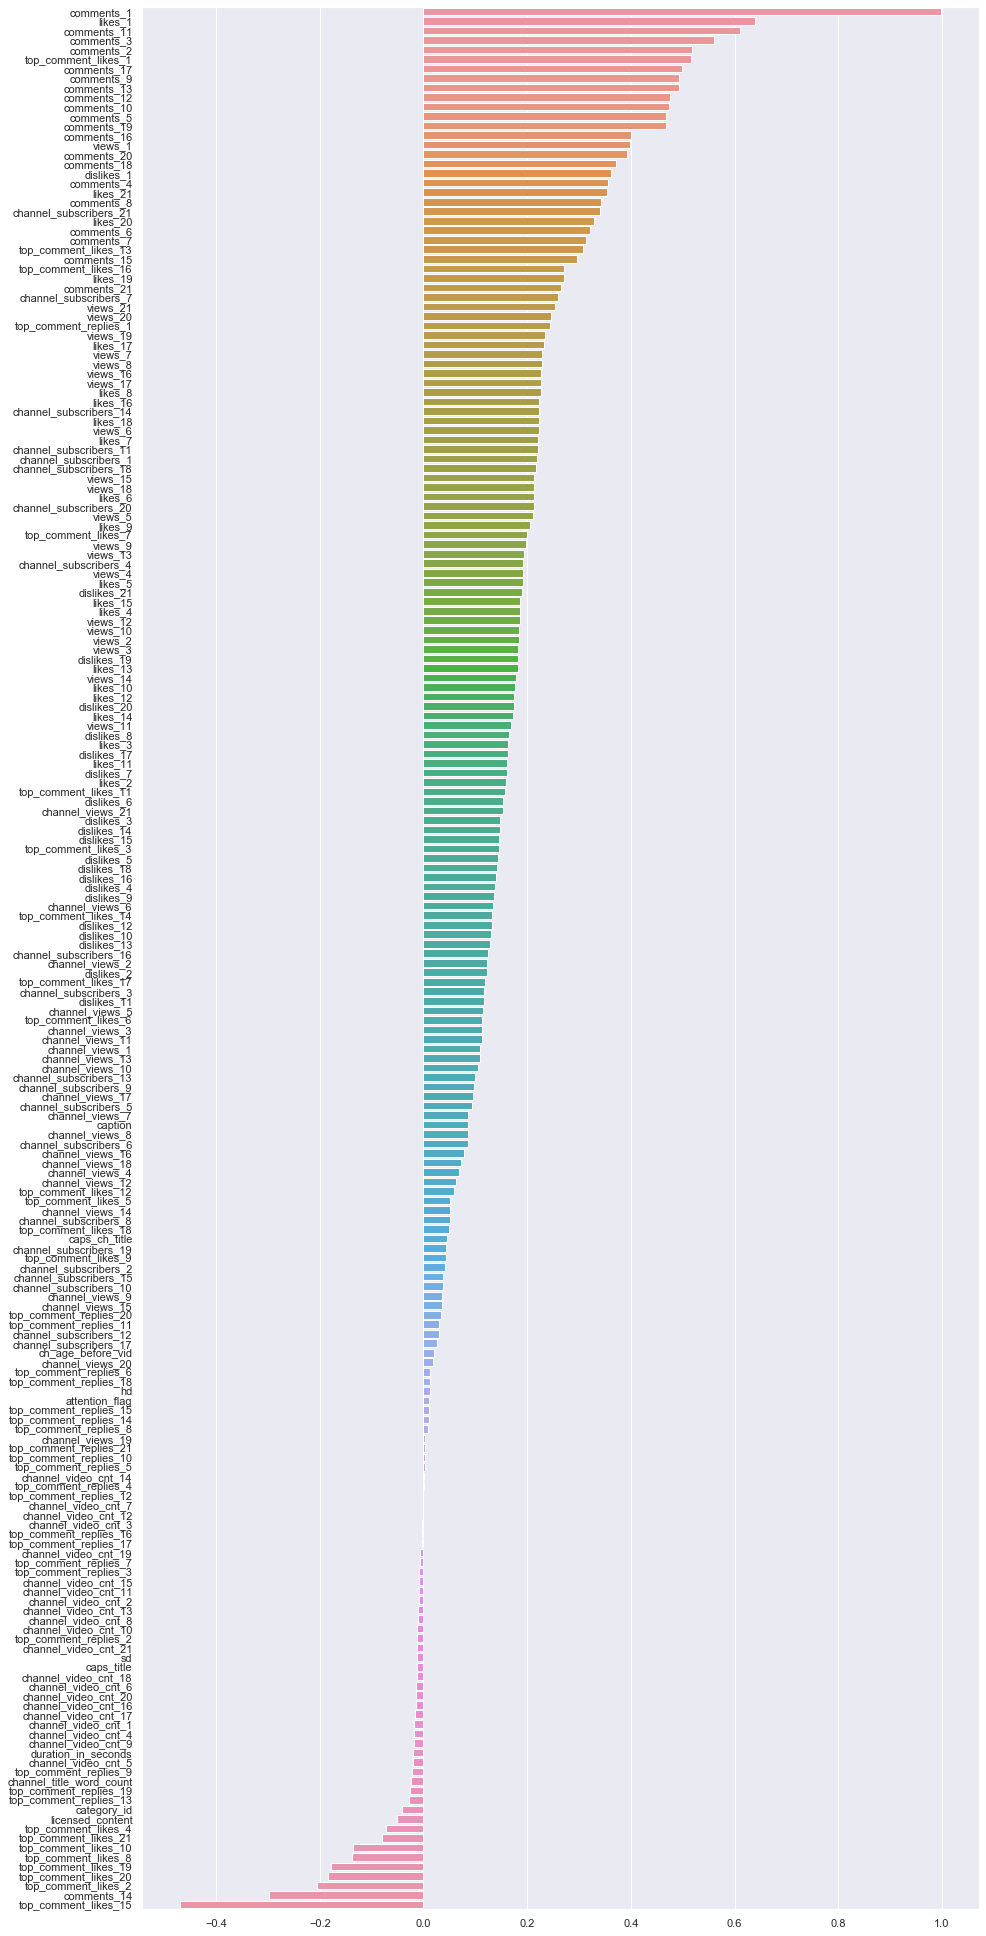

In [277]:
correlations_comments = X_train.corrwith(y_train["comments_22"]).sort_values(ascending=False)
plot_comments = sns.barplot(y=correlations_comments.index, x=correlations_comments)
plot_comments.figure.set_size_inches(15, 35)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [278]:
corr_df = pd.DataFrame(data={"features": correlations_comments.index, "importance": correlations_comments.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.25]["features"].values)

In [279]:
corr_df[corr_df["importance"] >= 0.1].features.values

array(['comments_1', 'likes_1', 'comments_11', 'comments_3', 'comments_2',
       'top_comment_likes_1', 'comments_17', 'comments_9', 'comments_13',
       'comments_12', 'comments_10', 'comments_5', 'comments_19',
       'comments_16', 'views_1', 'comments_20', 'comments_18',
       'dislikes_1', 'comments_4', 'likes_21', 'comments_8',
       'channel_subscribers_21', 'likes_20', 'comments_6', 'comments_7',
       'top_comment_likes_13', 'comments_15', 'top_comment_likes_16',
       'likes_19', 'comments_21', 'channel_subscribers_7', 'views_21',
       'views_20', 'top_comment_replies_1', 'views_19', 'likes_17',
       'views_7', 'views_8', 'views_16', 'views_17', 'likes_8',
       'likes_16', 'channel_subscribers_14', 'likes_18', 'views_6',
       'likes_7', 'channel_subscribers_11', 'channel_subscribers_1',
       'channel_subscribers_18', 'views_15', 'views_18', 'likes_6',
       'channel_subscribers_20', 'views_5', 'likes_9',
       'top_comment_likes_7', 'views_9', 'views_13',
  

In [280]:
X = df[important_features]
y = df[target_comments]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [281]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [282]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=cv_alpha)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 33.5822
Train RMSE = 15.9131


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

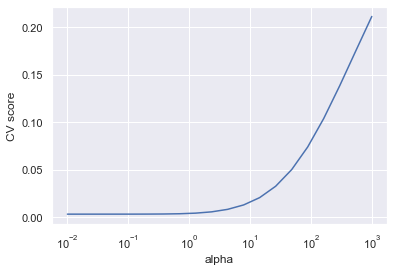

In [283]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [284]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [285]:
model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0008
Train RMSE = 0.0004
Test MSE = 0.00000065
Train MSE = 0.00000015


In [286]:
comments_model = model
comments_model

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [287]:
y_inverse = scaler.inverse_transform(y_pred)

In [288]:
y_inverse

array([[ 7964.68574564],
       [ 4780.42606621],
       [11454.70996996],
       ...,
       [ 2453.76835356],
       [ 1680.32926497],
       [ 5230.18003641]])

In [289]:
y_inverse = np.int64(y_inverse)

In [290]:
r2_score(y_test, y_inverse)

0.9999978730198016

In [301]:
pd.DataFrame(y_inverse, columns=["comments_forecast"])

comments_forecast
0                  7961
1                  4780
2                 11451
3                   843
4                 25988
...                 ...
2266                909
2267               2175
2268               2452
2269               1679
2270               5230

[2271 rows x 1 columns]

Получим предсказания просмотров по всем видео.

In [302]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [303]:
y_all_pred = comments_model.predict(X_scaled)
y_all_pred

array([[ 0.01142456],
       [-0.03048579],
       [-0.13866589],
       ...,
       [-0.10656312],
       [-0.06704994],
       [ 0.01572254]])

In [304]:
y_all_pred.shape

(7567, 1)

In [305]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [306]:
pd.DataFrame(np.int64(y_inv), columns=["comments_forecast"])

comments_forecast
0                  5748
1                  4196
2                   191
3                  1663
4                   388
...                 ...
7562                193
7563               1832
7564               1380
7565               2843
7566               5907

[7567 rows x 1 columns]

In [307]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["comments_forecast"])

In [308]:
forecast_["comments_forecast"].values

array([5748, 4196,  191, ..., 1380, 2843, 5907])

In [309]:
df_copy = df.copy()
df_copy = df_copy.assign(comments_forecast=pd.Series(forecast_["comments_forecast"].values))

In [310]:
df_copy[["video_id", "comments_22", "comments_forecast"]].sample(60)

video_id  comments_22  comments_forecast
4905  0U89ibg6HfI        709.0                775
2389  uh4jjSkszk4       1048.0               1053
1665  Ob4NC4D6zTU        587.0                616
2279  2FB6rQJ4czE       1957.0               2001
7236  jRvAEkqNOZk         71.0                129
5535  nBfSlyFxmEU        158.0                219
1022  MQzWZZEP550        808.0                866
7193  aTVNFIHMrZE        983.0               1038
6128  _mwL-KkeYxk       3248.0               3240
1302  s9MVLe-txNc       4465.0               4538
3981  A1mha-CSn5I         69.0                123
1694  x3i-TPav5KI        338.0                400
7105  27gbiPBu0bE       1697.0               1733
5037  cKtRXgC4hOI        416.0                471
4101  WQ4UNVV0224        720.0                767
6587  iLk599GRFVg      16210.0              16112
4187  lNg-4dnnZ-Y      10481.0              10665
4499  HT2WzKq89e4        430.0                475
4697  -U4Qiiw8IKY       7788.0               7925
5370  6WfNkoiSwKc        218.0                265
2500  n_gg55lxc_M       5859.0               5570
85    FW5vAykqQV8         12.0                 70
2768  3HDPqeM_H7c        120.0                180
6076  SIefbcUqnhw       2295.0               2372
143   F8tpgT-94Mw        675.0                724
1122  UHN1vu2Dq-k       7275.0               6509
1121  WQ51gq95-_0       1083.0               1134
7221  OVsC5fG-Qjk       2179.0               2248
6882  pm4EzbFN2Bw        597.0                656
4801  4oI28GBmsUA       1436.0               1484
6464  BR_yLovRUGU       1688.0               1742
5713  lm0V6U1-2JY       5199.0               5264
1589  t490zXLrQDE     143916.0             134013
4929  bI5mdxsPFpk       1347.0               1412
2779  c_TTR-lIycU        138.0                196
6892  X9C4IKBsMzo        962.0               1031
4851  x0QxfMtZIHs       2427.0               2438
3303  YnKJ7iBNypw       3547.0               3596
5349  U7fflGzJc-s       2711.0               2742
5783  Cw7P34TOWj4        600.0                633
4218  TKZviSs4pnU        522.0                572
4630  GBr9dWldmm0      18387.0              18384
6854  Orl7RGVGwaU       3898.0               4009
7427  Wi31fBY56KA        428.0                478
6156  o3f5aEz8IaA       4091.0               4027
1848  ta5mV1o4Ex8       1345.0               1410
2568  ffy4SNMFWi4      13732.0              13474
133   7jX8oXStAYE        251.0                311
1709  YN0vl1pBAl4      83509.0              84672
259   hNb1ITjzb34         91.0                150
1476  59QPLCGUDdY        736.0                756
4316  KffP8c-XLog       1305.0               1366
1679  RUW4s0M3yj4        463.0                523
2447  Xu1ZQEjTIMg       1982.0               2063
5563  waZyyWnNJ_Y      15621.0              15767
6004  CHZ6qsYlf-Y       1203.0               1197
5634  5KkSPYZAok0       1666.0               1702
753   9t5LZhgrShI       4841.0               4878
5767  46hZM0EpifA       7782.0               7026
6840  _2MTOYk-b_c         31.0                 90

In [311]:
X = df[features]
y = df[target_comments]

In [312]:
mu, sigma = 0, 0.001
noise_x = np.random.normal(mu, sigma, X_train.shape)
noise_x

array([[-4.36130129e-07,  1.04121899e-03,  4.93438759e-04, ...,
         9.28978592e-04,  7.96683821e-04,  9.44582743e-05],
       [-2.38576396e-03,  2.68810065e-04,  1.44291796e-04, ...,
         6.05726527e-04, -5.02531090e-04,  5.31228065e-04],
       [ 8.11700362e-05, -8.92969286e-04, -7.97554772e-04, ...,
        -3.66899892e-04,  3.69760039e-04,  2.26295630e-04],
       ...,
       [ 1.36138737e-03, -7.33800410e-04, -1.94826496e-03, ...,
         1.34084744e-03, -7.55889372e-04,  1.06629770e-03],
       [ 8.16238848e-04, -7.10224575e-04, -1.54262836e-03, ...,
        -8.56350686e-05,  1.12042920e-03, -7.04991868e-04],
       [-6.20959818e-04,  1.96049581e-03, -4.68291613e-04, ...,
        -3.14257922e-04,  5.08836474e-04, -1.09452124e-03]])

In [313]:
scaler = StandardScaler()

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

noise_x_tr = np.random.normal(mu, sigma, X_train.shape)
noise_x_test = np.random.normal(mu, sigma, X_test.shape)
noise_y_tr = np.random.normal(mu, sigma, y_train.shape)
noise_y_test = np.random.normal(mu, sigma, y_test.shape)

X_train_scaled += noise_x_tr
X_test_scaled += noise_x_test
y_train_scaled += noise_y_tr
y_test_scaled += noise_y_test

model = Ridge(alpha=best_alpha)
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0017
Train RMSE = 0.0014
Test MSE = 0.00000300
Train MSE = 0.00000195


In [291]:
r2_score(y_test_scaled, y_pred)

0.9999978736456593

## Прогнозируем просмотры, лайки, дизлайки, комментарии

In [292]:
import pandas as pd

df = pd.read_csv("growth_df_btw_ids21.tsv", sep='\t')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Среди всех столбцов выделяем признаки – все численные характеристики, кроме стастических показателей за 7 дней.

In [293]:
import numpy as np

numeric_data = df.select_dtypes([np.number])
numeric_features = numeric_data.columns

features = [item for item in numeric_features if not item.endswith("22")]

In [294]:
features

['licensed_content',
 'caption',
 'category_id',
 'views_1',
 'views_2',
 'views_3',
 'views_4',
 'views_5',
 'views_6',
 'views_7',
 'views_8',
 'views_9',
 'views_10',
 'views_11',
 'views_12',
 'views_13',
 'views_14',
 'views_15',
 'views_16',
 'views_17',
 'views_18',
 'views_19',
 'views_20',
 'views_21',
 'likes_1',
 'likes_2',
 'likes_3',
 'likes_4',
 'likes_5',
 'likes_6',
 'likes_7',
 'likes_8',
 'likes_9',
 'likes_10',
 'likes_11',
 'likes_12',
 'likes_13',
 'likes_14',
 'likes_15',
 'likes_16',
 'likes_17',
 'likes_18',
 'likes_19',
 'likes_20',
 'likes_21',
 'dislikes_1',
 'dislikes_2',
 'dislikes_3',
 'dislikes_4',
 'dislikes_5',
 'dislikes_6',
 'dislikes_7',
 'dislikes_8',
 'dislikes_9',
 'dislikes_10',
 'dislikes_11',
 'dislikes_12',
 'dislikes_13',
 'dislikes_14',
 'dislikes_15',
 'dislikes_16',
 'dislikes_17',
 'dislikes_18',
 'dislikes_19',
 'dislikes_20',
 'dislikes_21',
 'comments_1',
 'comments_2',
 'comments_3',
 'comments_4',
 'comments_5',
 'comments_6',
 'comm

В зависимости от задачи (подзадачи) таргеты будут разными.

In [295]:
target_4 = ["views_22", "comments_22", "likes_22", "dislikes_22"]
target_views = ["views_22"]
target_likes = ["likes_22"]
target_dislikes = ["dislikes_22"]
target_comments = ["comments_22"]

In [296]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target_4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

Для решения задачи хотелось бы обучить линейную регрессию, необходимо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и таргетом. Первостепенный показатель -- просмотры, поэтому будем отталкиваться от них.

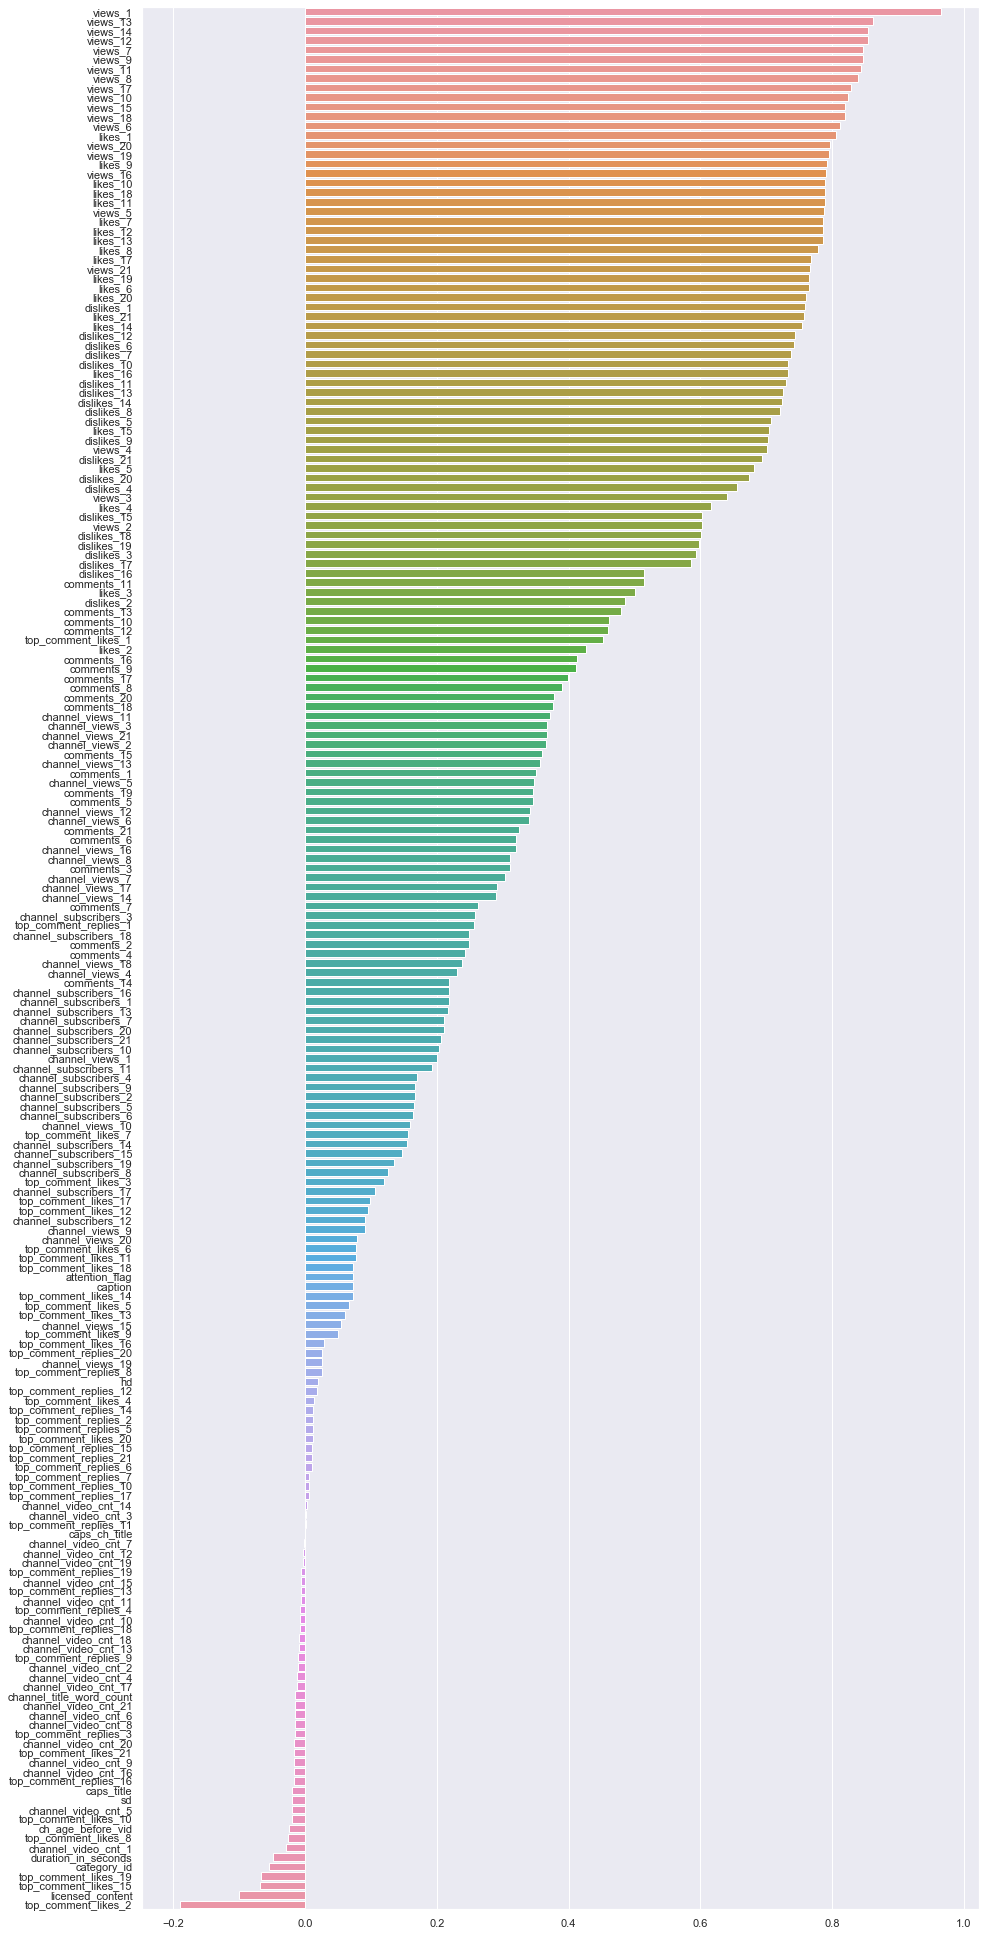

In [298]:
correlations_views = X_train.corrwith(y_train["views_22"]).sort_values(ascending=False)
plot_views = sns.barplot(y=correlations_views.index, x=correlations_views)
plot_views.figure.set_size_inches(15, 35)

В ходе экспериментов было выявлено, что лучшее качество модели достигается, если взять признаки с коэффициентом Пирсона не меньше 0.5.

Выделим наиболее важные признаки.

In [299]:
corr_df = pd.DataFrame(data={"features": correlations_views.index, "importance": correlations_views.values})
important_features = list(corr_df[np.abs(corr_df.importance) >= 0.2]["features"].values)
important_features

['views_1',
 'views_13',
 'views_14',
 'views_12',
 'views_7',
 'views_9',
 'views_11',
 'views_8',
 'views_17',
 'views_10',
 'views_15',
 'views_18',
 'views_6',
 'likes_1',
 'views_20',
 'views_19',
 'likes_9',
 'views_16',
 'likes_10',
 'likes_18',
 'likes_11',
 'views_5',
 'likes_7',
 'likes_12',
 'likes_13',
 'likes_8',
 'likes_17',
 'views_21',
 'likes_19',
 'likes_6',
 'likes_20',
 'dislikes_1',
 'likes_21',
 'likes_14',
 'dislikes_12',
 'dislikes_6',
 'dislikes_7',
 'dislikes_10',
 'likes_16',
 'dislikes_11',
 'dislikes_13',
 'dislikes_14',
 'dislikes_8',
 'dislikes_5',
 'likes_15',
 'dislikes_9',
 'views_4',
 'dislikes_21',
 'likes_5',
 'dislikes_20',
 'dislikes_4',
 'views_3',
 'likes_4',
 'dislikes_15',
 'views_2',
 'dislikes_18',
 'dislikes_19',
 'dislikes_3',
 'dislikes_17',
 'dislikes_16',
 'comments_11',
 'likes_3',
 'dislikes_2',
 'comments_13',
 'comments_10',
 'comments_12',
 'top_comment_likes_1',
 'likes_2',
 'comments_16',
 'comments_9',
 'comments_17',
 'comments

In [300]:
X = df[important_features]
y = df[target_4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Подберём коэффициент регуляризации с помощью кросс-валидации.

In [301]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
regr_cv = RidgeCV(alphas=list(np.arange(0.1, 10, 0.1)))
model_cv = regr_cv.fit(X_std, y)
cv_alpha = model_cv.alpha_

In [302]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(Ridge(alpha=cv_alpha))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 7899.9026
Train RMSE = 3881.2518


Подберём коэффициент регуляризации по сетке с помощью кросс-валидации.

Best alpha = 0.0100


Text(0, 0.5, 'CV score')

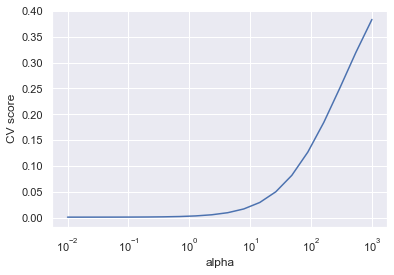

In [303]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train_scaled)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

Попробуем улучшить качество модели, стандартизируя признаки и целевую переменную.

In [304]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [305]:
model = MultiOutputRegressor(Ridge(alpha=best_alpha))
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_test_scaled, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train_scaled, y_train_pred, squared=False))
print("Test MSE = %.8f" % mean_squared_error(y_test_scaled, y_pred, squared=True))
print("Train MSE = %.8f" % mean_squared_error(y_train_scaled, y_train_pred, squared=True))

Test RMSE = 0.0011
Train RMSE = 0.0006
Test MSE = 0.00000132
Train MSE = 0.00000040


In [306]:
target4_model = model
target4_model

MultiOutputRegressor(estimator=Ridge(alpha=0.01, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=False, random_state=None,
                                     solver='auto', tol=0.001),
                     n_jobs=None)

In [307]:
from sklearn.metrics import r2_score

r2_score(y_test_scaled, y_pred)

0.9999976318741663

Чтобы увидеть прогнозы, перейдём к исходной шкале.

In [308]:
y_inverse = scaler.inverse_transform(y_pred)

In [309]:
y_inverse

array([[1.17800882e+07, 7.96386992e+03, 2.54817861e+05, 1.79520724e+04],
       [5.85737968e+05, 4.78169767e+03, 7.75324174e+04, 1.21863781e+03],
       [1.48852831e+07, 1.14547763e+04, 2.09757131e+05, 1.66131325e+04],
       ...,
       [7.23647119e+05, 2.45292037e+03, 1.24218050e+04, 5.78400526e+02],
       [7.95723436e+04, 1.68207161e+03, 1.11054601e+04, 9.65966114e+01],
       [4.60938744e+06, 5.22764037e+03, 3.54449744e+05, 3.62153005e+03]])

In [310]:
y_inverse = np.int64(y_inverse)

In [311]:
pd.DataFrame(y_inverse, columns=["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"])

views_forecast  comments_forecast  likes_forecast  dislikes_forecast
0           11780088               7963          254817              17952
1             585737               4781           77532               1218
2           14885283              11454          209757              16613
3             990782                845           14256                494
4           19059483              25989          660504              17358
...              ...                ...             ...                ...
2266          158010                909           12813                215
2267          229629               2176           16837                347
2268          723647               2452           12421                578
2269           79572               1682           11105                 96
2270         4609387               5227          354449               3621

[2271 rows x 4 columns]

Получим предсказания просмотров по всем видео.

In [312]:
df_scaler = StandardScaler()
X_scaled = df_scaler.fit_transform(X)
y_scaled = df_scaler.fit_transform(y)

In [313]:
y_all_pred = target4_model.predict(X_scaled)
y_all_pred

array([[-0.14313587,  0.01149632,  0.15753373, -0.12235099],
       [-0.12635979, -0.03055041, -0.12039527, -0.13180307],
       [-0.24871159, -0.13865939, -0.25426886, -0.15779571],
       ...,
       [-0.20015609, -0.10653875, -0.24750459, -0.14011481],
       [-0.18265501, -0.06701544, -0.21279648, -0.05104668],
       [ 0.11489218,  0.01572906,  0.52851345,  0.060809  ]])

In [314]:
y_all_pred.shape

(7567, 4)

In [315]:
y_inv = df_scaler.inverse_transform(y_all_pred)

In [316]:
pd.DataFrame(np.int64(y_inv), columns=["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"])

views_forecast  comments_forecast  likes_forecast  dislikes_forecast
0            1126782               5750          122758                744
1            1285333               4194           42494                584
2             128978                192            3832                144
3             523551               1664            8240                322
4             118267                388            3255                136
...              ...                ...             ...                ...
7562           91886                193            2308                 57
7563         1079967               1831           38271               1799
7564          587880               1381            5786                443
7565          753283               2844           15809               1952
7566         3565422               5907          229894               3847

[7567 rows x 4 columns]

In [317]:
forecast_ = pd.DataFrame(np.int64(y_inv), columns=["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"])

In [318]:
forecast_[["views_forecast", "comments_forecast", "likes_forecast", "dislikes_forecast"]].values

array([[1126782,    5750,  122758,     744],
       [1285333,    4194,   42494,     584],
       [ 128978,     192,    3832,     144],
       ...,
       [ 587880,    1381,    5786,     443],
       [ 753283,    2844,   15809,    1952],
       [3565422,    5907,  229894,    3847]])

In [319]:
df_copy = df.copy()
df_copy = df_copy.assign(views_forecast=pd.Series(forecast_["views_forecast"].values))
df_copy = df_copy.assign(comments_forecast=pd.Series(forecast_["comments_forecast"].values))
df_copy = df_copy.assign(likes_forecast=pd.Series(forecast_["likes_forecast"].values))
df_copy = df_copy.assign(dislikes_forecast=pd.Series(forecast_["dislikes_forecast"].values))

In [320]:
df_copy[["video_id", "views_22", "views_forecast", "likes_22", "likes_forecast", "dislikes_22", "dislikes_forecast", "comments_22", "comments_forecast"]].head(100)

video_id   views_22  views_forecast   likes_22  likes_forecast  \
0   HfGRNUOqhLk  1092141.0         1126782   123464.0          122758   
1   Kk5naOEL3gQ  1264719.0         1285333    41523.0           42494   
2   4bKuBuPB_QA    90201.0          128978     2644.0            3832   
3   eYOIhHu2gho   477820.0          523551     7070.0            8240   
4   0NDPSeDiYBI    79062.0          118267     2063.0            3255   
..          ...        ...             ...        ...             ...   
95  CMIndaI7Xfg  1560280.0         1616798    25125.0           26247   
96  EJDEhhN4stQ  2882425.0         2947563  1006123.0         1004144   
97  gPeUqezt8hM   321625.0          356477    35318.0           36037   
98  WNW1kw_DJQI   503837.0          528778     7799.0            8951   
99  YA4hoJiAg2g   378178.0          405350    12296.0           13311   

    dislikes_22  dislikes_forecast  comments_22  comments_forecast  
0         701.0                744       5719.0               5750  
1         571.0                584       4162.0               4194  
2         112.0                144        134.0                192  
3         281.0                322       1584.0               1664  
4         101.0                136        325.0                388  
..          ...                ...          ...                ...  
95        780.0                836       5359.0               5486  
96        972.0               1000      36692.0              37018  
97        771.0                792       1536.0               1564  
98        337.0                356       2172.0               2119  
99        272.0                305        298.0                354  

[100 rows x 9 columns]

In [321]:
df_copy.describe().duration_in_seconds

count      7567.000000
mean       1287.669089
std        3129.233478
min           3.000000
25%         208.000000
50%         557.000000
75%        1094.000000
max      107354.000000
Name: duration_in_seconds, dtype: float64

In [103]:
from scipy.stats import hmean

In [104]:
hmean(df_copy.loc[0, ["views_forecast", "likes_forecast", "dislikes_forecast", "comments_forecast"]].values)

2619.459369412477

1. Среднее геометрическое
2. Квантили с приоритетом от 1 до 4
3. Произведение 1 и 2
4. Шкала от 0 до 1
5. Сортировка по результату 4
6. Вывод первых n% от таблицы через head()